# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Clustering




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 2 is due February 20th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- Problem 1 + Problem 2 = 75 points ; Problem 3 = 25 points
- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans
from gap_statistic import OptimalK
#from sklearn.datasets.samples_generator import make_blobs


<hr style="height:2pt">

<div class="theme">*Handy* Algorithms </div>


    
In this assignment, you will be working with data collected from a motion capture camera system. The system was used to record 14 different users performing 5 distinct hand postures with markers attached to a left-handed glove. A set of markers on the back of the glove was used to establish a local coordinate system for the hand, and 8 additional markers were attached to the thumb and fingers of the glove. A total of 24 features were collected based on observations from the camera system. Two other variables in the dataset were the ID of the user and the posture that the user made.

These data have been preprocessed, including transformation to the local coordinate system of the record, removal of outliers, and removal of missing data.

The dataset `postures_clean.csv` contains 38,943 rows and 26 columns. Each row corresponds to a single frame as captured by the camera system. The data are represented in the following manner:

`Class (type: Integer). The hand posture of the given observation, with`

`1 = Fist (with thumb out)`

`2 = Stop (hand flat)`

`3 = Point1 (point with index finger)`

`4 = Point2 (point with index and middle fingers)`

`5 = Grab (fingers curled as if to grab)`

`User (type: Integer). The ID of the user that contributed the record.`

`X0, Y0, Z0, X1, Y1, Z1,..., X7, Y7, Z7 (type: Real). The x-coordinate, y-coordinate, and z-coordinate of the eight unlabeled marker positions.`


Start by reading the dataset into a pandas data frame.

In [3]:
#your code herepostures_clean.
%config IPCompleter.greedy=True


postures_clean_df = pd.read_csv('data/postures_clean.csv')
postures_clean_df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
0,1,0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,...,-47.909511,10.028439,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124
1,1,0,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,...,-25.243914,10.277516,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553
2,1,0,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,...,-67.660208,87.019172,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279
3,2,0,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,...,-74.307346,58.421362,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147
4,2,0,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,...,-71.629823,20.573646,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243


<div class='exercise'>Problem 1: Clustering with k-means </div>

(a) After appropriate pre-processing (but not scaling) run the k-means clustering algorithm, using the `KMeans` class from sklearn.cluster, with the number of clusters corresponding to the number of users, `n_init` of 46, and 109 as the random seed. Add the result as a new column called `Cluster14` to your data frame.

In [4]:
# your code here
clustering_df = postures_clean_df.drop(['Class', 'User'], axis=1)
num_users = postures_clean_df.User.nunique()
kmeans = KMeans(n_clusters=num_users, init='random',
                n_init=46, random_state=109).fit(clustering_df)
postures_clean_df['Cluster14'] = clustering_df['Cluster14'] = kmeans.labels_

(b) Use the function below to visualize the results for k-means on a random sample of 2,000 observations (it will take the sample for you). Does 14 clusters seem to make sense?

In [5]:
from sklearn.decomposition import PCA

def plot_clusters(full_data, group_col, scaling_mode):
    marker_types = [".", "v", "1", "^", "s", "p", "P", "3", "H", "<", "|", "_", "x", "*"]
    marker_colors = np.concatenate([np.array(plt.cm.tab10.colors),np.array(plt.cm.Pastel1.colors)])
    
    feature_columns = [colname for colname in list(full_data.columns) if colname not in {'Class','User','Cluster14','Cluster5'}]
    features_only = full_data[feature_columns]
    
    # make a scaled df if needed, (but don't scale cluster labels)
    if scaling_mode == True:
        scaler = StandardScaler()
        scaled_features = pd.DataFrame(scaler.fit_transform(features_only), columns=feature_columns)
    elif scaling_mode == False:
        scaled_features = features_only
    else:
        raise ValueError("Unexpected value for scaling_mode")

    # fit PCA to the whole scaled data
    fitted_pca = PCA().fit(scaled_features)

    # take a sample of the whole scaled data
    scaled_sample = scaled_features.sample(2000, random_state=109)

    # apply the PCA transform on the sample
    pca_sample = pd.DataFrame(fitted_pca.transform(scaled_sample), columns = ["PCA{}".format(i) for i in range(len(scaled_sample.columns.values))])
    
    pca_sample.index = scaled_sample.index ### New statement
    # re-include a cluster label for the pca data
    if 'Cluster14' in full_data.columns.values:
        pca_sample['Cluster14'] = full_data.loc[pca_sample.index, "Cluster14"]
    if 'Cluster5' in full_data.columns.values:
        pca_sample['Cluster5'] = full_data.loc[pca_sample.index, "Cluster5"]
    plt.figure(figsize=(11,8.5))
    for i, (cluster_id, cur_df) in enumerate(pca_sample.groupby([group_col])):

        pca1_scores = cur_df.iloc[:,0]
        pca2_scores = cur_df.iloc[:,1]
        plt.scatter(pca1_scores, pca2_scores, label=cluster_id, c=marker_colors[i].reshape(1,-1), marker=marker_types[i])

    plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
    plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
    plt.legend()
    plt.show()

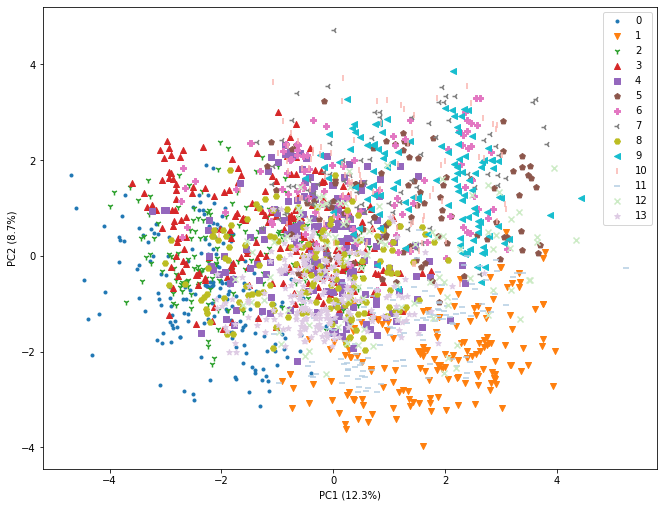

In [6]:
plot_clusters(clustering_df,'Cluster14', True)

Given the lack of visual distinction betwee any of the cluster when visualizing the clusters and the top 2 primary components, 14 clusters does not seem to make sense.

(c) Plot the silhouette scores using the function below, from lecture. Give it a 10% sample of the data to speed the visualization. How reasonable does the clustering seem based on this plot? How does it compare to the information in the plot above?

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 14, the average silhouette_score is 0.06743615310066292.


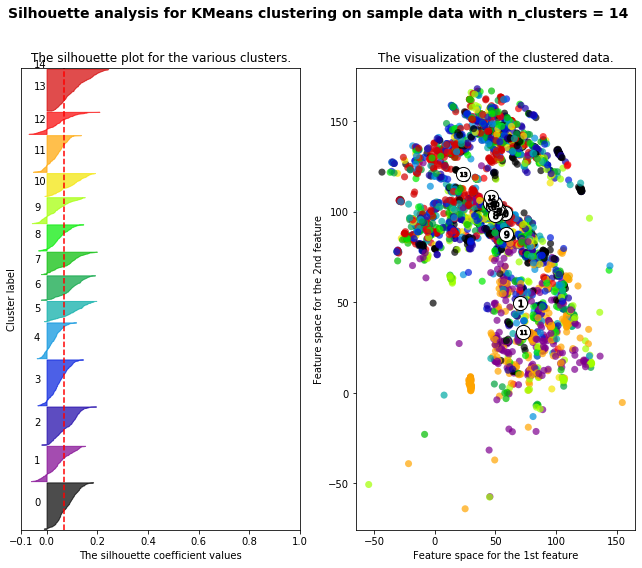

In [8]:
# your code here
sil_df = clustering_df.sample(frac=0.1)
silplot(sil_df.drop('Cluster14', axis=1).values, sil_df.Cluster14, kmeans)


Again, the clustering is not great. In class we learned that clusters with a silhouette score around 1 are well clustered, and clusters with a score around 0 lie between two clusters. My average silhouette score of 0.067 is VERY close to 0, indicating that my clustering was not effective. This plot does show that there are a couple of members of cluster 13 that do seem to be well clustered, which was not easy to interpret from the prior clustering chart.

(d) Repeat all of the above steps, but attempting to group by posture rather than by user. That is : 

(i) Run the k-means algorithm with 5 centroids instead of 14, creating a variable named `Cluster5` and adding it to the dataset. 

(ii) Visualize the results for k-means. Does 5 clusters seem to make sense from this plot?

(iii) Plot the silhouette scores on a 10% sample of the data. How reasonable does the clustering seem based on this plot?

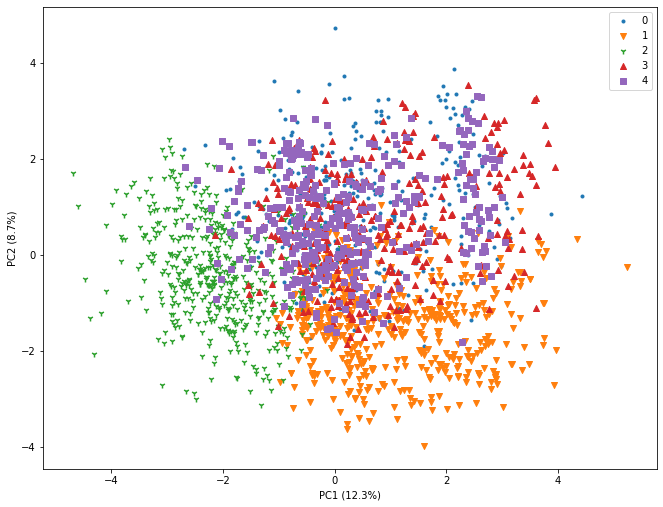

In [9]:
# your code here
clustering_df = postures_clean_df.drop(['Class', 'User'], axis=1)
num_classes = postures_clean_df.Class.nunique()
kmeans = KMeans(n_clusters=num_classes, init='random',
                n_init=46, random_state=109).fit(clustering_df)
clustering_df['Cluster5'] = kmeans.labels_
plot_clusters(clustering_df,'Cluster5', True)



Even with 5 clusters, I am not seeing much visual distinction between any of the 5 classes. It probably should be noted that the first 2 principle components do not explain that much of the variance in my data, which may affect my ability to visualize cluster distinctions. However, this still seems pretty bad.

For n_clusters = 5, the average silhouette_score is 0.07293198828521222.


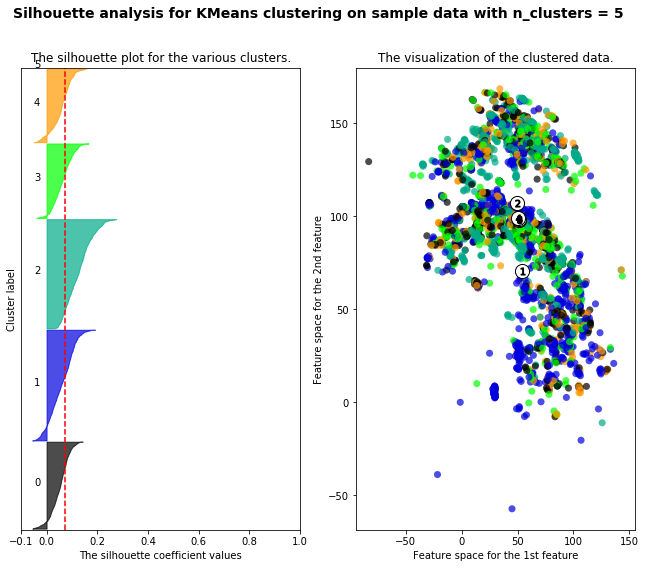

In [10]:
sil_df = clustering_df.sample(frac=0.1)
silplot(sil_df.drop('Cluster5', axis=1).values, sil_df.Cluster5, kmeans)

Again, a average silhouette score of 0.072 is pretty bad and doesn't indicate strong distinctions between the clusters. I'd thus argue that 5 clusters still doesn't make a  ton of sense.

(e) What do the results suggest? Does this make sense in the context of what we know about the problem?

The results suggest that there aren't a lot of similarities in how given users position their hands when making different hand postures, and moreover, that there aren't a lot of similarities in the ways that different users make the same posture. This surprises me, as I'd assume there are number of distinct ways people make the same posture. Perhaps by choosing the best k for k-means via cross-validation, we would find that, in fact, if we split each posture into a couple distinct ways of showing it, visible and distinct clusters will appear. For now, though, this data seems hard to cluster.

<div class='exercise'> <b> Problem 2: Other Ks  </b> </div>

In the previous problem, we examined the results of running k-means with 5 and 14 centroids on the postures data. In this problem, we will investigate a broader range of possible cluster sizes, with a borader range of metrics. 

**For all of these questions, you should work with a sample of 2,000 data points drawn with `pd.sample` and a random seed of 109.**

(a) Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,15\}.$
 

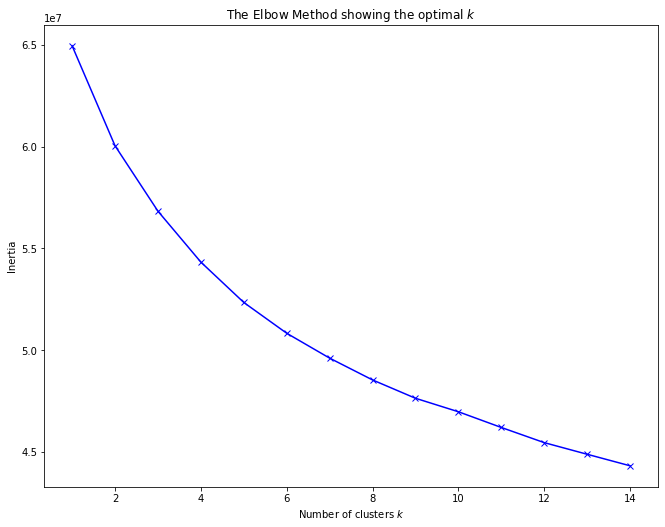

In [11]:
clustering_df = postures_clean_df.drop(['Class', 'User', 'Cluster14'], axis=1).sample(n=2000,random_state=109)
wss = []
for i in range(1,15):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(clustering_df)
    wss.append(fitx.inertia_)

plt.figure(figsize=(11,8.5))
plt.plot(range(1,15), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

(b) Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,15\}$. Plot the results. 

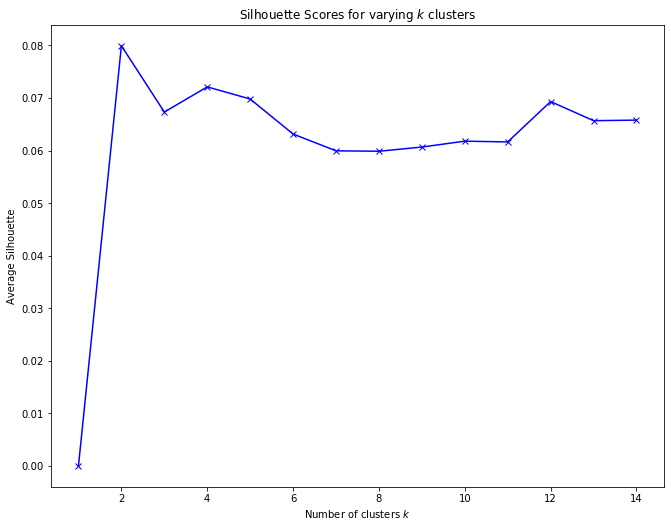

In [12]:
from sklearn.metrics import silhouette_score

scores = [0]
for i in range(2,15):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(clustering_df)
    score = silhouette_score(clustering_df, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,15), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('Silhouette Scores for varying $k$ clusters')
plt.show()


(c) Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Plot the results. 

/Users/Simon/.conda/envs/cs109b/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Optimal clusters:  14


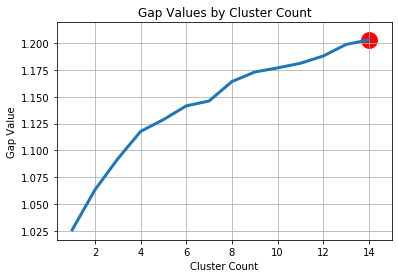

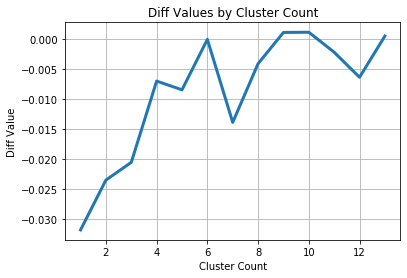

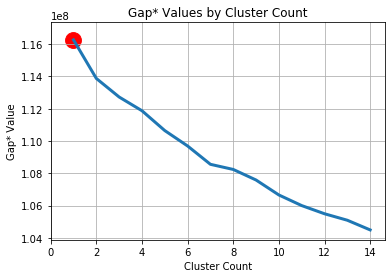

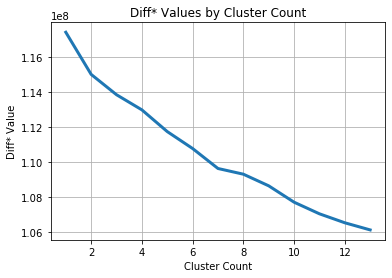

In [13]:
from gap_statistic import OptimalK
from sklearn.datasets.samples_generator import make_blobs

gs_obj = OptimalK(n_jobs=1)

n_clusters = gs_obj(clustering_df.values, n_refs=50,
                    cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)
gs_obj.plot_results()

(d) After analyzing the plots produced by all three of these measures, discuss the number of k-means clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you surmise about this dataset.

While the gap statistic does not support this, I'd argue that the avg. sil score plot and elbow plot suggest that 2 clusters is the ideal number. At 2, the elbow plot has the closest thing to a "knee", though it is hardly as pronounced as the example in class. Similarly, the avg. sil score is the best at 2, followed by 4 and 12. Overall, it seems as though this data does not have clear clusters in it, and I am thus skeptical about all of my conclusions. Perhaps the data collection was flawed? I've visualized the result of 2 K-means clusters below and the distinction is pretty clear between the two groups, so I'll go with that.

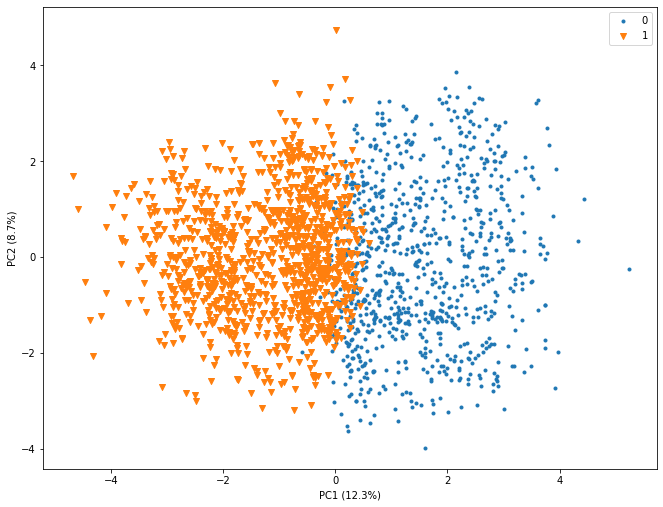

In [14]:
plotting_df = postures_clean_df.drop(['Class', 'User'], axis=1)
kmeans = KMeans(n_clusters=2, init='random',
                n_init=46, random_state=109).fit(plotting_df)
plotting_df['Cluster5'] = kmeans.labels_
plot_clusters(plotting_df,'Cluster5', True)


<div class='exercise'> <b> Problem 3: Alternative Algorithms  </b> </div>

(e) Run DBSCAN on the data. How many clusters are found, and how well does this clustering perform on e.g. silhouette score, excluding the points not assigned to any cluster?  
*Note*: Do not use a sample of the data. Running the algorithm may take up to 5-10 minutes.

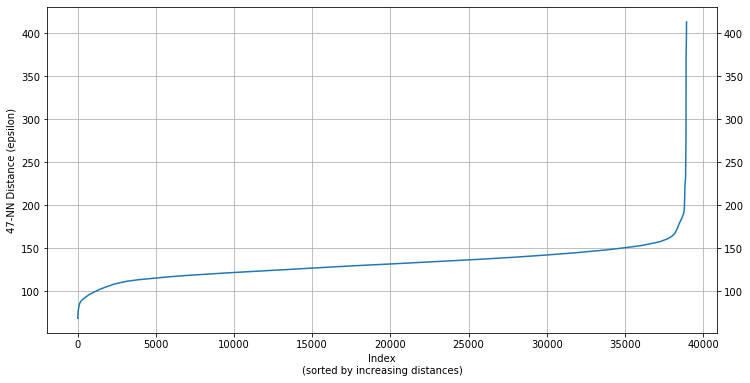

In [15]:
#your code here
from sklearn.neighbors import NearestNeighbors

dbscan_df = postures_clean_df.drop(['Class', 'User', 'Cluster14'], axis=1)

# x-axis is each individual data point, numbered by an artificial index
# y-axis is the distance to its 2nd closest neighbor
def plot_epsilon(df, min_samples):
    fitted_neigbors = NearestNeighbors(n_neighbors=min_samples).fit(df)
    distances, indices = fitted_neigbors.kneighbors(df)
    dist_to_nth_nearest_neighbor = distances[:,-1]
    plt.figure(figsize=(12,6))
    plt.plot(np.sort(dist_to_nth_nearest_neighbor))
    plt.xlabel("Index\n(sorted by increasing distances)")
    plt.ylabel("{}-NN Distance (epsilon)".format(min_samples-1))
    plt.tick_params(right=True, labelright=True)
    plt.grid()
min_samples = 2*len(dbscan_df.columns)
plot_epsilon(dbscan_df,min_samples)





Using min_samples = twice the number of predictors (so 48). I decided on an epsilon value of 190, as that is approximately where the plot above starts speeding up rapidly.

In [16]:
fitted_dbscan = DBSCAN(eps=190).fit(dbscan_df)
labels = fitted_dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)



Estimated number of clusters: 3


From DBSCAN, I get 3 clusters. The avg silhouette score of these 3 clusters, omitting every data point which was assigned the label of -1 (which means it was in no cluster) is calculated below.

In [17]:
clustered_indices = np.argwhere(fitted_dbscan.labels_!=-1)
clustered_indices = np.ndarray.flatten(clustered_indices)
dbscan_cluster_df = dbscan_df.loc[clustered_indices,:].reindex()
cluster_labels = np.array(fitted_dbscan.labels_)
filtered_labels = cluster_labels[cluster_labels!=-1]
ss = silhouette_score(dbscan_cluster_df, filtered_labels)
print("DBSCAN Silhouette Score: ", ss)
print("Label Count By Class [0,1,2]:",np.bincount(filtered_labels))




DBSCAN Silhouette Score:  0.4523547750698143
Label Count By Class [0,1,2]: [38857    15     4]


This Silhouette score is significantly better than any of the others I got earlier, but it's also artificial in that I've omitted points which were not assigned a cluster, which was not an option earlier. While there are only 67 point I'm Omitting, this is significant. Moreover, when I look at the counts of each class above, i have ~40k in one class, with 15 and 4 in the other 2. This hardly counts as 3 clusters. 

(f) Hierarchical clustering. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results, and describe the cluster size(s) the plot suggests. What level of aggregation is suggested by the silhouette score?

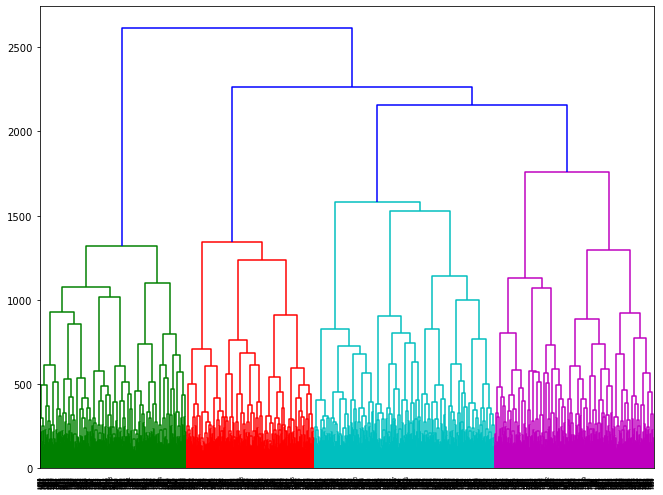

In [18]:
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

plt.figure(figsize=(11,8.5))
dist_mat = pdist(clustering_df, metric="euclidean")
ward_data = hac.ward(dist_mat)

hac.dendrogram(ward_data);
plt.show()



While there are no huge gaps shown on the dendrogram, the obvious clusters are the 4 depicted w/ different colors above. However, in order to dig into this better, I'll compare the silhouette score to the number of clusters formed by dendrogram below.

[Text(0, 0.5, 'Silhouette Score'),
 Text(0.5, 0, 'Number of Clusters per Hierarchical Clustering'),
 Text(0.5, 1.0, 'Number of Clusters vs Sil. Score from Heirarchical Clustering')]

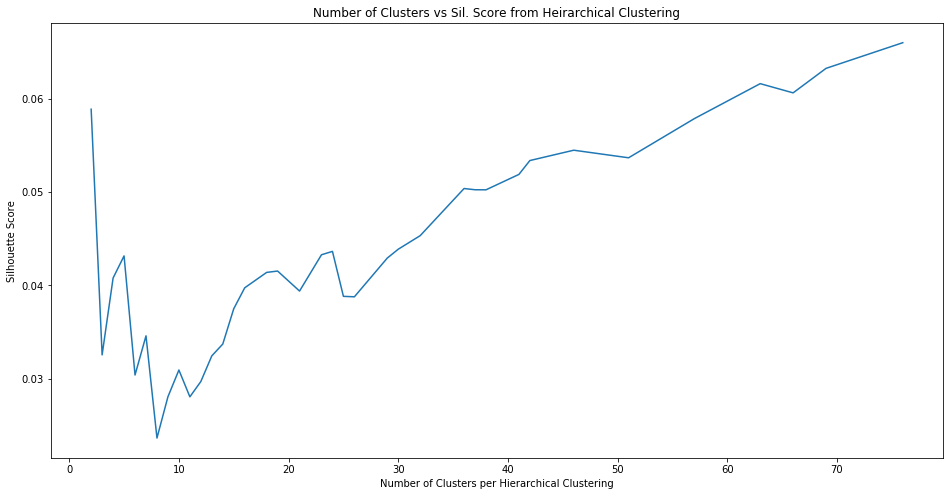

In [19]:
#your code here
tol_list = np.linspace(500, 2400, 100)
num_clusters = []
hac_sil_scores = []
for tol in tol_list:
    labellings = hac.fcluster(ward_data, t=tol, criterion='distance')
    num = len(np.bincount(labellings))-1
    num_clusters.append(num)
    hac_sil = silhouette_score(clustering_df, labellings)
    hac_sil_scores.append(hac_sil)   
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(num_clusters, hac_sil_scores)

ax.set(xlabel='Number of Clusters per Hierarchical Clustering', ylabel='Silhouette Score',title="Number of Clusters vs Sil. Score from Heirarchical Clustering")

From this plot, obviously 2 clusters is the best performance. I know from the Dendrogram above that those 2 clusters are more balanced than the DBSearch clusters. 4 clusters, as predicted earlier, also preforms relatively well. Finally, it looks like 24 clusters has a similar sil. score to 4 clusters, so perhaps that clustering is worth investigating more. Overall, the best avg. sil. scores are between 0.06 and 0.04, which is still really bad, so it's hard to make too much of these results, given the lack of distinction in the data.

(g) Overall, what do you conclude about the number and kind of clusters in this data set?

Given the inconclusiveness of the results, I'm unable to draw any strong conclusions about the number and king of clusters in this data set. While the result the DBScan clustering had by far the best Avg. Sil. Score, It's "3" clusters were essentially just 1 big cluster with 15 and 4 in the other two clusters. Moreover, that score was a bit artificial in that i excluded everything without a cluster label from the dataset, which I did not do in any other case. Using Hierarchical clustering, I found that 2 or 4 clusters are perhaps the best. 2 was also my best result form k-means clustering, so that gives me more confidence in my answer. However, as mentioned earlier, the extremely low avg. sil. score even in the best case demonstrates that, while 2 may be the best number of clusters, these are not good clusters. Overall, my conclusion is that this data is a mess, and though I expected there to be good clusters which formed around the similarities in the way people make similar hand.

In a more general sense, a takeaway from this exercise is that when a number of different clustering algorithms are performed on the same dataset, and the results of each vary significantly, perhaps this dataset does not lend itself to clustering in the first place. 